# Final Project: Admission Prediction from NHAMCS
## Progress report: Summary of dataset
### DS5559: Big Data Analysis
### Thomas Hartka, Alicia Doan, Michael Langmayr
Created: 6/21/20  

## Data Source

Our data is from the National Hospital Ambulatory Medical Care Survey (NHAMCS).  This is a stratified sample of data gathered from Emergency Departments (EDs) from around the United States collected by the CDC.  Data from the years 2007-2017 are publically available at: 

https://www.cdc.gov/nchs/ahcd/datasets_documentation_related.htm

The data is provided in tabular format.  Each row represents a patient encounter and each column is a variable associated with the encounter.  We have previously converted the STATA files (orginal format) into CSVs.  We then used Pyspark to combine the 11 years of data into a large table, then stored the data in a parquet data structure.    

In [1]:
# set directories
data_dir = "../data"
results_dir = "../results"

In [2]:
# import python libraries
import pandas as pd
import numpy as np

# set up pyspark
from pyspark.sql import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()

In [8]:
# load parquet data
NHAMCS = spark.read.parquet(data_dir + "/NHAMCS.2007-2017")

In [4]:
# example of data
NHAMCS.select(NHAMCS.columns[:10]).show(5)

+------+-----+--------+---+-------+--------+---+-----------------+------+--------------------+
|VMONTH|VYEAR|   VDAYR|AGE|ARRTIME|WAITTIME|LOV|         RESIDNCE|   SEX|               ETHUN|
+------+-----+--------+---+-------+--------+---+-----------------+------+--------------------+
|  July| 2009|Saturday| 36|   2125|       5|296|Private residence|Female|Not Hispanic or L...|
|  July| 2009|  Friday| 40|   1904|       5| 86|Private residence|Female|Not Hispanic or L...|
|  July| 2009|  Friday| 76|   1034|       0| 86|Private residence|  Male|Not Hispanic or L...|
|  July| 2009|Thursday| 27|     25|      63|190|Private residence|Female|Not Hispanic or L...|
|  July| 2009|Thursday| 71|   1940|      40|230|Private residence|Female|Not Hispanic or L...|
+------+-----+--------+---+-------+--------+---+-----------------+------+--------------------+
only showing top 5 rows



## Number of Records

In [5]:
# count number of records
NHAMCS.count()

305897

There are 305,897 records in the 11 years of data we obtained.  
  
We made a table examine which variables were available for each year.  In the following table a '1' indicates there was at least one non-null value for the variable; a '0' indicates all values were null (meaning the variable was not collected that year).  

In [6]:
# load variable data
NHAMCS_vars = pd.read_csv(results_dir + "/NHAMCS_vars_by_year.csv")

# display table of variables by year
NHAMCS_vars[['YEAR','CHF','CKD','CAD','COPD']].set_index('YEAR').transpose()

YEAR,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
CHF,0,0,1,1,1,1,1,1,1,1,1
CKD,0,0,0,0,0,0,0,1,1,1,1
CAD,0,0,0,0,0,0,0,1,1,1,1
COPD,0,0,0,0,0,1,1,1,1,1,1


This shows that several of the potentially valuable predictors (CKD-Chronic Kideny Disease, CAD-Coronary Artery Disease, etc) were not collected until 2014.  We therefore decided to limit our analysis to 2014-2017.

In [48]:
# convert year to integer from string
NHAMCS = NHAMCS.withColumn("YEAR", NHAMCS["YEAR"].cast(IntegerType()))

# filter for years 2014-2017
NHAMCS = NHAMCS.filter(NHAMCS['YEAR']>=2014)

In [49]:
# count records 2014-2017
NHAMCS.count()

81081

We are therefore left with 81,081 records for analysis for the years 2014-2017.  

## Outcome

Our outcome of interest is hospital admission.  We are would like to predict which patients will require admission to the hospital after ED evaluation and which patients can be discharged.  Being able to predict admission at that the time of patient presentation to the ED would be useful in terms of mobilizing resources.  If a patient has a high likelihood of admission, then a ward bed could be made ready and the admitting physicians could be informed.  

NHAMCS records disposition data in several variables.  If a patient is admitted to the local hospital or transferred to another hospital (psychiatric or other), they will be considered positive for admission.

ADM_OUTCOME = (ADMITHOSP = "Yes) OR (TRANPSYC = "Yes") OR (TRANOTH = "Yes") OR (OBSHOS = "Yes")
 

In [9]:
# create outcome variable
NHAMCS = NHAMCS.withColumn("ADM_OUTCOME", when((col("ADMITHOS")=="Yes") | \
                                                (col("TRANPSYC")=="Yes") | \
                                                (col("TRANOTH")=="Yes") | \
                                                (col("OBSHOS")=="Yes"), 1).otherwise(0))

In [50]:
# stats on outcome
NHAMCS.filter(NHAMCS['ADM_OUTCOME']==1).count()

9308

In [51]:
NHAMCS.filter(NHAMCS['ADM_OUTCOME']==0).count()

71773

In [52]:
## Admission rate overall
NHAMCS.filter(NHAMCS['ADM_OUTCOME']==1).count()/(NHAMCS.filter(NHAMCS['ADM_OUTCOME']==0).count() +NHAMCS.filter(NHAMCS['ADM_OUTCOME']==1).count())

0.11479878146544813

<***---Describe outcome stats----------***>


## Predictors

In [12]:
# count number of columns
len(NHAMCS.columns)

1220

From the years 2007-2017 there were 1,219 variables collected.  The exact variables collected varied by year.  In no year were all 1,219 data points collected for each encounter.  This data includes patient demographics, reason for visit, which tests were ordered, medications prescribed, and ED/hospital information. 
  
We want only use data that is available when the patient presents, which includes demographics, comorbidites, vital signs, and reason for visit.  We will not use tests orders, medications, or discharge diagnosis since these are not known on arrival. 
  
The following are our most likely predictors by category:

__Demographics__
* Age (AGE, AGER, ADEDAYS)
* Sex (SEX)
* Residence (RESIDNCE)
* Arrival time (ARRTIME)
* Year of visit (YEAR)

__Vital signs__
* Heart rate (PULSE)
* Temperature (TEMPF)
* Respiratory rate (RESPR)
* Blood pressure (BPSYS, BPDIAS)
* Oxygen saturation (POPCT)
* Pain scale (PAINSCALE)

__Comorbidities (known health problems__
* Alzheimer's disease (ALZHD)
* Asthma (ASTHMA)
* Coronary artery disease (CAD)
* Cancer (CANCER)
* Cerebrovascular disease (CEBVD)
* Congestive heart failure (CHF)
* Chronic kidney disease (CKD)
* Chronic obstructive pulmonary disease (COPD)
* Depression (DEPRN)
* Diabetes-type nunknown (DIABTYP0)
* Diabetes-type I (DIABTYP1)
* Diabetes-type II (DIABTYP2)
* HIV (EDHIV)
* End-stage renal disease/dialysis (ESRD)
* Alcohol abuse (ETOHAB)
* History of pulmonary embolism (HPE)
* Hypertension (HTN)
* Hyperlipidemia (HYPLIPID)
* Obesity (OBESITY)
* Obstructive sleep apnea (OSA)
* Osteoporosis (OSTPRSIS)
* Substance abuse (SUBSTAB)
* No chronic diseases (NOCHRON)
* Total number of chronic diseases (TOTCHRON)


__Reason for visit__
* Reason for visit-free text #1 (RFV1)
* Reason for visit-free text #2 (RFV2)
* Reason for visit-free text #3 (RFV3)
* Reason for visit-free text #4 (RFV4)
* Reason for visit-free text #5 (RFV5)
* Is this visit related to an injury/trauma, overdose/poisoning, or adverse effect of medical/surgical treatment? (INJURY)
* Did the injury/trauma, overdose/poisoning, or adverse effect of medical/surgical treatment occur within 72 hours prior to the date and time of this visit? (INJURY72)


In [55]:
####################
# ADD PREDICTOR STATS
####################
import pyspark.sql.functions as F

# Gender of patient
percentage_female = NHAMCS.filter(NHAMCS["SEX"] == "Female").count() / NHAMCS.count()
percentage_male = NHAMCS.filter(NHAMCS["SEX"] == "Male").count() / NHAMCS.count()

print("Percentage Female patients: {}, Male patients: {}".format(percentage_female, percentage_male))

Percentage Female patients: 0.5476005476005475, Male patients: 0.4523994523994524


In [56]:
# Patient's pulse during admission
avg = NHAMCS.select(F.mean('PULSE')).collect()[0]
stddev = NHAMCS.select(F.stddev('PULSE')).collect()[0]
NHAMCS = NHAMCS.withColumn("PULSE", NHAMCS["PULSE"].cast("float"))

# Quantiles
x25 = NHAMCS.approxQuantile('PULSE', [0.25], 0)
x5 = NHAMCS.approxQuantile('PULSE', [0.5], 0)
x75 = NHAMCS.approxQuantile('PULSE', [0.75], 0)

print("Average pulse of patient is {}".format(avg))
print("Quantiles: .25: {}, .5: {}, .75: {}".format(x25, x5, x75))
print("Standard deviation: {}".format(stddev))

Average pulse of patient is Row(avg(PULSE)=91.27690455399434)
Quantiles: .25: [76.0], .5: [88.0], .75: [102.0]
Standard deviation: Row(stddev_samp(PULSE)=23.084029913532127)


In [57]:
# BPSYS
avg = NHAMCS.select(F.mean('BPSYS')).collect()[0]
stddev = avg_age = NHAMCS.select(F.stddev('BPSYS')).collect()[0]
NHAMCS = NHAMCS.withColumn("BPSYS", NHAMCS["BPSYS"].cast("float"))

# Quantiles
x25 = NHAMCS.approxQuantile('BPSYS', [0.25], 0)
x5 = NHAMCS.approxQuantile('BPSYS', [0.5], 0)
x75 = NHAMCS.approxQuantile('BPSYS', [0.75], 0)

print("Average BPSYS of patient is {}".format(avg))
print("Quantiles: .25: {}, .5: {}, .75: {}".format(x25, x5, x75))
print("Standard deviation: {}".format(stddev))

Average BPSYS of patient is Row(avg(BPSYS)=133.45751479618772)
Quantiles: .25: [117.0], .5: [131.0], .75: [146.0]
Standard deviation: Row(stddev_samp(BPSYS)=23.771204333599794)


In [58]:
# TEMPF
avg = NHAMCS.select(F.mean('TEMPF')).collect()[0]
stddev = NHAMCS.select(F.stddev('TEMPF')).collect()[0]
NHAMCS = NHAMCS.withColumn("TEMPF", NHAMCS["TEMPF"].cast("float"))

# Quantiles
x25 = NHAMCS.approxQuantile('TEMPF', [0.25], 0)
x5 = NHAMCS.approxQuantile('TEMPF', [0.5], 0)
x75 = NHAMCS.approxQuantile('TEMPF', [0.75], 0)

print("Average temperature is {}".format(avg))
print("Quantiles: .25: {}, .5: {}, .75: {}".format(x25, x5, x75))
print("Standard deviation: {}".format(stddev))

Average temperature is Row(avg(TEMPF)=98.3023917487975)
Quantiles: .25: [97.80000305175781], .5: [98.19999694824219], .75: [98.5999984741211]
Standard deviation: Row(stddev_samp(TEMPF)=1.0299118245398284)


In [59]:
# POPCT
avg = NHAMCS.select(F.mean('POPCT')).collect()[0]
stddev = NHAMCS.select(F.stddev('POPCT')).collect()[0]
NHAMCS = NHAMCS.withColumn("POPCT", NHAMCS["POPCT"].cast("float"))

# Quantiles
x25 = NHAMCS.approxQuantile('POPCT', [0.25], 0)
x5 = NHAMCS.approxQuantile('POPCT', [0.5], 0)
x75 = NHAMCS.approxQuantile('POPCT', [0.75], 0)

print("Average POPCT is {}".format(avg))
print("Quantiles: .25: {}, .5: {}, .75: {}".format(x25, x5, x75))
print("Standard deviation: {}".format(stddev))

Average POPCT is Row(avg(POPCT)=97.30844376826681)
Quantiles: .25: [97.0], .5: [98.0], .75: [99.0]
Standard deviation: Row(stddev_samp(POPCT)=5.940603337921231)


In [60]:
# pain scale
painscales = NHAMCS.where(NHAMCS.PAINSCALE != 'Unknown')
avg = painscales.select(F.mean('PAINSCALE')).collect()[0]
stddev = painscales.select(F.stddev('PAINSCALE')).collect()[0]
painscales = painscales.withColumn("PAINSCALE", NHAMCS["PAINSCALE"].cast("float"))

# Quantiles
x25 = painscales.approxQuantile('PAINSCALE', [0.25], 0)
x5 = painscales.approxQuantile('PAINSCALE', [0.5], 0)
x75 = painscales.approxQuantile('PAINSCALE', [0.75], 0)

print("Average PAINSCALE is {}".format(avg))
print("Quantiles: .25: {}, .5: {}, .75: {}".format(x25, x5, x75))
print("Standard deviation: {}".format(stddev))

Average PAINSCALE is Row(avg(PAINSCALE)=4.840190870622131)
Quantiles: .25: [0.0], .5: [5.0], .75: [8.0]
Standard deviation: Row(stddev_samp(PAINSCALE)=3.685903934729506)


In [61]:
# Patient has asthma
percentage_yes = NHAMCS.filter(NHAMCS["ASTHMA"] == "Yes").count() / NHAMCS.count()
percentage_no = NHAMCS.filter(NHAMCS["ASTHMA"] == "No").count() / NHAMCS.count()

print("Percentage patients with asthma: {}, without: {}".format(percentage_yes, percentage_no))

Percentage patients with asthma: 0.09881476548143214, without: 0.9011852345185678


In [62]:
# Patient has CAD
percentage_yes = NHAMCS.filter(NHAMCS["CAD"] == "Yes").count() / NHAMCS.count()
percentage_no = NHAMCS.filter(NHAMCS["CAD"] == "No").count() / NHAMCS.count()

print("Percentage patients with CAD: {}, without: {}".format(percentage_yes, percentage_no))

Percentage patients with CAD: 0.05855872522539189, without: 0.9414412747746082


In [63]:
# Patient has CKD
percentage_yes = NHAMCS.filter(NHAMCS["CKD"] == "Yes").count() / NHAMCS.count()
percentage_no = NHAMCS.filter(NHAMCS["CKD"] == "No").count() / NHAMCS.count()

print("Percentage patients with CKD: {}, without: {}".format(percentage_yes, percentage_no))

Percentage patients with CKD: 0.023384023384023383, without: 0.9766159766159767


<***---Describe predictor stats----------***>

## Visualizations


<***---Add at least 5 graphs----------***>

Ideas:
- Visits per year
- Admission percentage vs age (AGER is categorical)
- Number of patients with comorbidites (histogram of TOTCHRON)
- Admission percentage vs total number of comorbidities (TOTCHRON)
- Age vs total number of comorbidities
- Admission percentage vs pain score

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

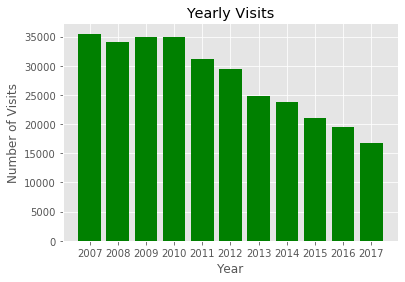

In [10]:
yearly_visits = NHAMCS.groupby('YEAR').count().toPandas().sort_values('YEAR')
plt.bar(yearly_visits['YEAR'], yearly_visits['count'], color='green')
plt.xlabel("Year")
plt.ylabel("Number of Visits")
plt.title("Yearly Visits")
plt.show()

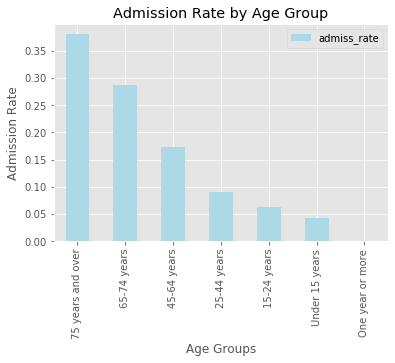

In [11]:
age_admission = NHAMCS.groupby('AGER').pivot("ADM_OUTCOME").count()
age_admission = age_admission.withColumn('admiss_rate', age_admission['1']/(age_admission['1']+age_admission['0'])).toPandas().sort_values('admiss_rate', ascending = False)


age_labels = age_admission['AGER'].values
fig = age_admission[['admiss_rate']].plot(kind='bar', facecolor='lightblue')
fig.set_xticklabels(age_labels)
fig.set_title('Admission Rate by Age Group')
fig.set_xlabel('Age Groups')
fig.set_ylabel('Admission Rate')
plt.show()

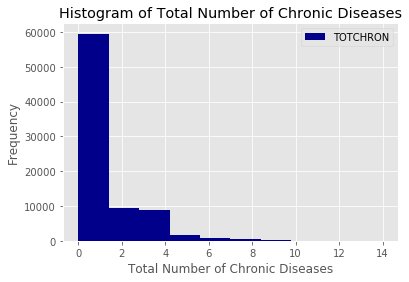

In [12]:
comorbid_data = NHAMCS.filter(NHAMCS.YEAR >= 2014).select("TOTCHRON").toPandas()
comorbid_data['TOTCHRON'] = np.where(comorbid_data['TOTCHRON']== "'None' box and all item fields are blank" , '0', comorbid_data['TOTCHRON'])

comorbid_data['TOTCHRON'] = comorbid_data['TOTCHRON'].astype(int)

comorbid_data[['TOTCHRON']].plot(kind='hist', facecolor='darkblue')
plt.xlabel("Total Number of Chronic Diseases")
plt.ylabel("Frequency")
plt.title("Histogram of Total Number of Chronic Diseases")
plt.show()

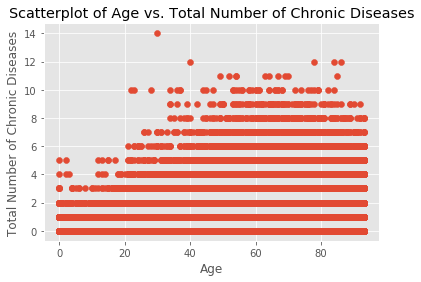

In [31]:
age_comorbid_data = NHAMCS.filter(NHAMCS.YEAR >= 2014).select("TOTCHRON",'AGE').toPandas()
age_comorbid_data['TOTCHRON'] = np.where(age_comorbid_data['TOTCHRON']== "'None' box and all item fields are blank" , '0', age_comorbid_data['TOTCHRON'])

age_comorbid_data['TOTCHRON'] = age_comorbid_data['TOTCHRON'].astype(int)
age_comorbid_data['AGE'] = np.where(age_comorbid_data['AGE']== 'Under one year' , '0', age_comorbid_data['AGE'])
age_comorbid_data['AGE'] = np.where(age_comorbid_data['AGE']== '93 years and over' , '93', age_comorbid_data['AGE'])

age_comorbid_data['AGE'] = age_comorbid_data['AGE'].astype(int)
plt.scatter(age_comorbid_data.AGE, age_comorbid_data.TOTCHRON)
plt.ylabel("Total Number of Chronic Diseases")
plt.xlabel("Age")
plt.title("Scatterplot of Age vs. Total Number of Chronic Diseases")
plt.show()


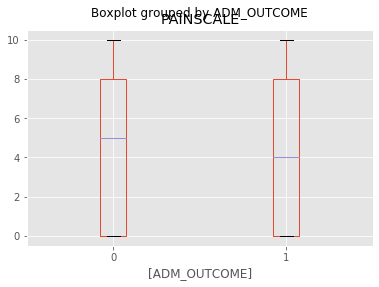

In [45]:
pain_admiss = NHAMCS.filter(NHAMCS.YEAR >= 2014).select("PAINSCALE",'ADM_OUTCOME').toPandas()
#Remove blanks and unknowns
pain_admiss =pain_admiss[~pain_admiss['PAINSCALE'].isin(['Blank', 'Unknown'])]
pain_admiss['PAINSCALE'] = pain_admiss['PAINSCALE'].astype(int)


pain_admiss.boxplot(by='ADM_OUTCOME')
plt.show()

In [64]:
!jupyter nbconvert --to pdf `pwd`/*.ipynb


[NbConvertApp] Converting notebook /sfs/qumulo/qhome/ad2ew/ds5559/final_project/code/010-Combine_data.ipynb to pdf
[NbConvertApp] Writing 52055 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 59137 bytes to /sfs/qumulo/qhome/ad2ew/ds5559/final_project/code/010-Combine_data.pdf
[NbConvertApp] Converting notebook /sfs/qumulo/qhome/ad2ew/ds5559/final_project/code/100-Determine_data_by_year.ipynb to pdf
[NbConvertApp] Writing 31762 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there w